## Pacotes Necessários

```bash
pipenv run python -m spacy download en_core_web_trf
```

In [31]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
from spacy import load

## Carregando o modelo pré-treinado - https://spacy.io/models/en#en_core_web_trf
nlp = load('en_core_web_trf')

## Funções

In [32]:
###############################################################
#### AVALIANDO O % NAS COLUNAS QUE CONTEM VALORES NULOS #######
###############################################################
def percentual_nulos(df,lista_avaliar):
    total_linhas = df.shape[0]
    lista_percentual = []

    ## SALVANDO A SAIDA DA FUNCAO QUE RETORNA A QTDE DE NULOS POR COLUNA
    teste_nulos = df.isnull().sum()

    ## SALVA O RESULTADO EM UM DATAFRAME
    teste_nulos = pd.DataFrame({'COLUNA':teste_nulos.index, 'VALOR':teste_nulos.values})

    ## SELECIONA APENAS AS COLUNAS QUE PRECISAM SER AVALIADAS
    teste_nulos = teste_nulos.query('COLUNA == @lista_avaliar')

    ## SALVA O NOME DAS COLUNAS EM UMA LISTA
    colunas = teste_nulos.COLUNA.tolist()

    ## SALVA OS VALORES DE MISSINGS POR COLUNA EM UMA LISTA
    valor = teste_nulos.VALOR.tolist()

    # obtenha a lista de tuplas de duas listas
    # e mescle-as usando zip().
    lista_de_tuplas = list(zip(colunas, valor))

    # converte uma lista de tuplas num DataFrame
    df_avaliado = pd.DataFrame(lista_de_tuplas, columns=['colunas', 'valor'])

    ## FILTRANDO NO DF APENAS COLUNAS QUE POSSUEM DADOS
    for i,coluna in enumerate(colunas):
        percentual = round((valor[i]/total_linhas)*100,2)
        lista_percentual.append(percentual)

    ## Transformando a lista de percentuais em um df pandas
    lista_percentual = pd.DataFrame(lista_percentual, columns = ['percentual'])

    ## Juntando a informação de percentual ao df 
    df_avaliado = pd.concat([df_avaliado,lista_percentual], axis = 1)

    return(df_avaliado)

In [33]:
## Carregando o conjunto de dados
df = pd.read_csv('./datasets/reviews_data.csv')
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [34]:
###############################################################################
########### AVALIANDO O PERCENTUAL DE NULOS NAS COLUNAS #######################
###############################################################################

lista_avaliar = list(df.columns)
df_avaliado = percentual_nulos(df,lista_avaliar)
df_avaliado.head(10)

,colunas,valor,percentual
0,name,0,0.00
1,location,0,0.00
2,Date,0,0.00
3,Rating,145,17.06
4,Review,0,0.00
5,Image_Links,0,0.00


Como é possível observar, há 145 valores nulos na coluna Rating que é a variável target. Esses dados nulos seriam correspondentes aos dados de teste para previsão depois do modelo treinado. No final deste código, os dados serão separados em treino e teste e, nos dados de treino não deverá conter nenhum dado nulo na variável target.

In [35]:
### Dados Gerais sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


A coluna Date contém valores de data, contudo o tipo identificado é do tipo object, é necessário alterar o tipo da coluna para utilizá-la de forma adequada em gráficos.

In [36]:
## Copiando a coluna original e tratando em uma coluna adicionada
df['date_treat'] = df['Date']
df['date_treat'] = df['date_treat'].str.split('Reviewed').str[1] # separando a string usando como criterio o /
df['date_treat'] = df['date_treat'].str.strip() # retirando os espacos em branco no inicio e final da string

## Retirando o ponto de algumas strings
df['date_treat'] = df['date_treat'].str.replace('.', '')

## Passando o tipo de dado para datetime
df['date_treat'] = pd.to_datetime(df['date_treat'], format = "mixed")

## Alterando a ordem das colunas e retirando a coluna Image_Links que não será utilizada
df = df[['name',
         'location',
         'Date',
         'date_treat',
         'Rating',
         'Review']]

df.head()

,name,location,Date,date_treat,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",2023-07-16,5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",2023-07-05,5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",2023-05-26,5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...


Agora que o campo de data foi ajustado, faz-se o tratamento do campo location separando a string em cidade e estado.

In [37]:
### Criando a coluna city com a informação que vem antes da vírgula na coluna location
df.insert(2, "city", df["location"].str.split(",").str[0])
df['city'] = df['city'].str.strip() # retirando os espacos em branco no inicio e final da string

### Criando a coluna state com a informação que vem depois da vírgula na coluna location
df.insert(3, "state", df["location"].str.split(",").str[1])
df['state'] = df['state'].str.strip() # retirando os espacos em branco no inicio e final da string

df.head()

,name,location,city,state,Date,date_treat,Rating,Review
0,Helen,"Wichita Falls, TX",Wichita Falls,TX,"Reviewed Sept. 13, 2023",2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL",Apopka,FL,"Reviewed July 16, 2023",2023-07-16,5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA",Cranberry Twp,PA,"Reviewed July 5, 2023",2023-07-05,5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA",Seattle,WA,"Reviewed May 26, 2023",2023-05-26,5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR",Gresham,OR,"Reviewed Jan. 22, 2023",2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...


In [38]:
## A coluna Rating deveria possuir apenas valores inteiros pois trata-se de um score. 
## Alterando o tipo de dado
df = df.astype({'Rating': float})
df.Rating.unique()

array([ 5.,  1.,  2.,  3.,  4., nan])

Um score de 1 a 5 possui características que podem ser resumidas em um score de 0 a 2, sendo:

- Negative : 0

- Neutral : 1

- Positive : 2

Isto pode ajudar na performance do modelo de classificação e facilita também a compreensão dos resultados, ou seja, se o consumidor está satisfeito (positive), neutro (neutral) ou insatisfeito (negative) em relação ao serviço prestado.

In [39]:
df["rating_treat"] = df["Rating"]
df["rating_treat"] = df["rating_treat"].replace([1,2],0)
df["rating_treat"] = df["rating_treat"].replace(3,1)
df["rating_treat"] = df["rating_treat"].replace([4,5],2)
df.head()

,name,location,city,state,Date,date_treat,Rating,Review,rating_treat
0,Helen,"Wichita Falls, TX",Wichita Falls,TX,"Reviewed Sept. 13, 2023",2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...,2.0
1,Courtney,"Apopka, FL",Apopka,FL,"Reviewed July 16, 2023",2023-07-16,5.0,** at the Starbucks by the fire station on 436...,2.0
2,Daynelle,"Cranberry Twp, PA",Cranberry Twp,PA,"Reviewed July 5, 2023",2023-07-05,5.0,I just wanted to go out of my way to recognize...,2.0
3,Taylor,"Seattle, WA",Seattle,WA,"Reviewed May 26, 2023",2023-05-26,5.0,Me and my friend were at Starbucks and my card...,2.0
4,Tenessa,"Gresham, OR",Gresham,OR,"Reviewed Jan. 22, 2023",2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...,2.0


In [40]:
## Variáveis de tempo úteis na análise gráfica
df['month'] = df['date_treat'].dt.month
df['year'] = df['date_treat'].dt.year
df['day_of_week'] = df['date_treat'].dt.dayofweek
df = df.astype({'day_of_week': int})

## Ordem dos dias da semana
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

df.head()

,name,location,city,state,Date,date_treat,Rating,Review,rating_treat,month,year,day_of_week
0,Helen,"Wichita Falls, TX",Wichita Falls,TX,"Reviewed Sept. 13, 2023",2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...,2.0,9,2023,2
1,Courtney,"Apopka, FL",Apopka,FL,"Reviewed July 16, 2023",2023-07-16,5.0,** at the Starbucks by the fire station on 436...,2.0,7,2023,6
2,Daynelle,"Cranberry Twp, PA",Cranberry Twp,PA,"Reviewed July 5, 2023",2023-07-05,5.0,I just wanted to go out of my way to recognize...,2.0,7,2023,2
3,Taylor,"Seattle, WA",Seattle,WA,"Reviewed May 26, 2023",2023-05-26,5.0,Me and my friend were at Starbucks and my card...,2.0,5,2023,4
4,Tenessa,"Gresham, OR",Gresham,OR,"Reviewed Jan. 22, 2023",2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...,2.0,1,2023,6


### Tratar a coluna Review com NLP

Vamos aplicar a lemmatização a coluna Review para reduzir a dimensionalidade do texto e melhorar a performance do modelo.

### Lemmatização
Lemmatização é o processo de converter uma palavra para sua forma base, chamada lema.

O objetivo da lemmatização é padronizar palavras que aparecem em formas flexionadas (com prefixos, sufixos, variações de gênero ou número, etc) para sua forma canônica.

Por exemplo:

amando -> amar
casas -> casa
felizmente -> feliz
Em processamento de linguagem natural, a lemmatização é utilizada como uma etapa de pré-processamento para normalizar o texto antes de outras análises.

Isso ajuda a agrupar diferentes formas flexionadas de uma mesma palavra, de modo que elas possam ser analisadas como uma única palavra base.

Alguns exemplos de uso da lemmatização:

Na classificação de texto, para tratar palavras flexionadas como equivalentes.
Em buscas, para encontrar variantes flexionadas de termos de busca.
Em análise de sentimentos, para unir variantes como "feliz" e "felicidade".
Para reduzir a dimensionalidade do texto ao unir variações.
Para normalização antes de treinar embeddings de palavras.
Em resumo, a lemmatização é uma técnica de processamento de linguagem natural que converte palavras para sua forma base ou lema, com o objetivo de padronizar e melhorar a análise do texto.

In [41]:
# Exemplo de Lemmatização
text = "This is a sample sentence with some stop words"
doc = nlp(text)

# Remove stop words
filtered_tokens = [token.text for token in doc if not token.is_stop]

# Print the text excluding stop words
print(filtered_tokens)

['sample', 'sentence', 'stop', 'words']


In [42]:
# Exemplo em uma linha para entendimento

text = df.iloc[0,7] # Está selecionando a linha 0, coluna index 7 do dataframe df.
text = str(text).lower() # Converte o texto para minúsculas 

text = re.sub('\[.*?\]', '', text) # Remove colchetes e conteúdo
text = re.sub('https?://\S+|www\.\S+', '', text) # Remove URLs
text = re.sub('<.*?>+', '', text) # Remove tags HTML

text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove pontuação
text = re.sub('\n', '', text) # Remove quebras de linha
text = re.sub('\w*\d\w*', '', text) # Remove palavras com números

print('Texto antes: \n', text)

doc = nlp(text)
print('Doc: \n', doc)

text = " ".join([text.lemma_ for text in doc]) # Lemmatiza o texto
print('Depois de lemma: \n', text) 

# Remove stop words
text = " ".join([token.text for token in doc if not token.is_stop])  
print('Depois de stopwords: \n', text)

Texto antes: 
 amber and ladonna at the starbucks on southwest parkway are always so warm and welcoming there is always a smile in their voice when they greet you at the drivethru and their customer service is always spoton they always get my order right and with a smile i would actually give them more than  stars if they were available
Doc: 
 amber and ladonna at the starbucks on southwest parkway are always so warm and welcoming there is always a smile in their voice when they greet you at the drivethru and their customer service is always spoton they always get my order right and with a smile i would actually give them more than  stars if they were available
Depois de lemma: 
 amber and ladonna at the starbucks on southwest parkway be always so warm and welcoming there be always a smile in their voice when they greet you at the drivethru and their customer service be always spoton they always get my order right and with a smile I would actually give they more than   star if they be 

In [43]:
# Aplicando em todas as linhas
def nlp_function(text):

    ## Apply lower case
    text = str(text).lower()

    ## Removing caracteres
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    #print('Texto antes: \n', text)
    
    ## Applying the trained model
    doc = nlp(text)
    #print('Doc: \n', doc)
    
    ## Lemmatization functions: its primary objective is to break down words into their essential roots, making it easier to identify resemblances.
    text = " ".join([text.lemma_ for text in doc])
    #print('Depois de lemma: \n', text)

    # Remove stop words: some words are not meaningful, so we remove them.
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    text=" ".join(filtered_tokens)
    #print('Depois de stopwords: \n', text)

    return text

df["review_treat"] = df["Review"].apply(nlp_function)
df.head()

,name,location,city,state,Date,date_treat,Rating,Review,rating_treat,month,year,day_of_week,review_treat
0,Helen,"Wichita Falls, TX",Wichita Falls,TX,"Reviewed Sept. 13, 2023",2023-09-13,5.0,Amber and LaDonna at the Starbucks on Southwes...,2.0,9,2023,2,amber ladonna starbucks southwest parkway warm...
1,Courtney,"Apopka, FL",Apopka,FL,"Reviewed July 16, 2023",2023-07-16,5.0,** at the Starbucks by the fire station on 436...,2.0,7,2023,6,starbucks fire station altamonte springs f...
2,Daynelle,"Cranberry Twp, PA",Cranberry Twp,PA,"Reviewed July 5, 2023",2023-07-05,5.0,I just wanted to go out of my way to recognize...,2.0,7,2023,2,wanted way recognize starbucks employee billy ...
3,Taylor,"Seattle, WA",Seattle,WA,"Reviewed May 26, 2023",2023-05-26,5.0,Me and my friend were at Starbucks and my card...,2.0,5,2023,4,friend starbucks card work thankful worker pai...
4,Tenessa,"Gresham, OR",Gresham,OR,"Reviewed Jan. 22, 2023",2023-01-22,5.0,I’m on this kick of drinking 5 cups of warm wa...,2.0,1,2023,6,kick drinking cups warm water work instacart...


In [44]:
df.day_of_week.unique()

array([2, 6, 4, 3, 5, 1, 0])

([<matplotlib.axis.XTick at 0x2a8c1b010>,
 [Text(0, 0, 'Sunday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday')])

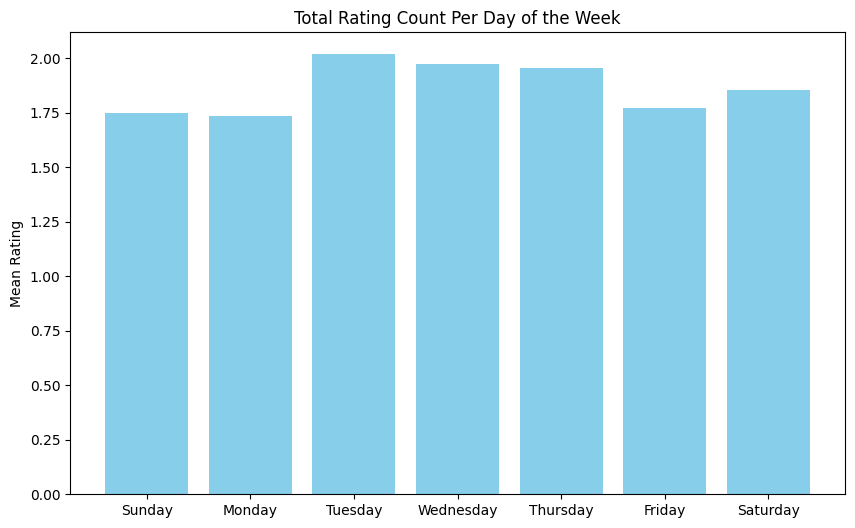

In [45]:
## Rodar depois que retirar os NaN
df_graph = df.copy()
df_graph = df_graph.groupby(['day_of_week'])['Rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(df_graph['day_of_week'], df_graph['Rating'], color='skyblue')
plt.ylabel('Mean Rating')
plt.title('Total Rating Count Per Day of the Week')
plt.xticks(df_graph['day_of_week'], labels=day_order)

In [46]:
df_treat = df[["month","day_of_week", "year", "Rating", "Review", "review_treat", "city", "state"]].copy()
df_treat.dropna(axis=0, inplace=True)
df_treat.head()

,month,day_of_week,year,Rating,Review,review_treat,city,state
0,9,2,2023,5.0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway warm...,Wichita Falls,TX
1,7,6,2023,5.0,** at the Starbucks by the fire station on 436...,starbucks fire station altamonte springs f...,Apopka,FL
2,7,2,2023,5.0,I just wanted to go out of my way to recognize...,wanted way recognize starbucks employee billy ...,Cranberry Twp,PA
3,5,4,2023,5.0,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...,Seattle,WA
4,1,6,2023,5.0,I’m on this kick of drinking 5 cups of warm wa...,kick drinking cups warm water work instacart...,Gresham,OR


In [47]:
# Detectar valores ausentes em todas as colunas de um DataFrame
df_treat.isna().sum()

month           0
day_of_week     0
year            0
Rating          0
Review          0
review_treat    0
city            0
state           0
dtype: int64

In [48]:
df_treat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703 entries, 0 to 749
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         703 non-null    int32  
 1   day_of_week   703 non-null    int64  
 2   year          703 non-null    int32  
 3   Rating        703 non-null    float64
 4   Review        703 non-null    object 
 5   review_treat  703 non-null    object 
 6   city          703 non-null    object 
 7   state         703 non-null    object 
dtypes: float64(1), int32(2), int64(1), object(4)
memory usage: 43.9+ KB


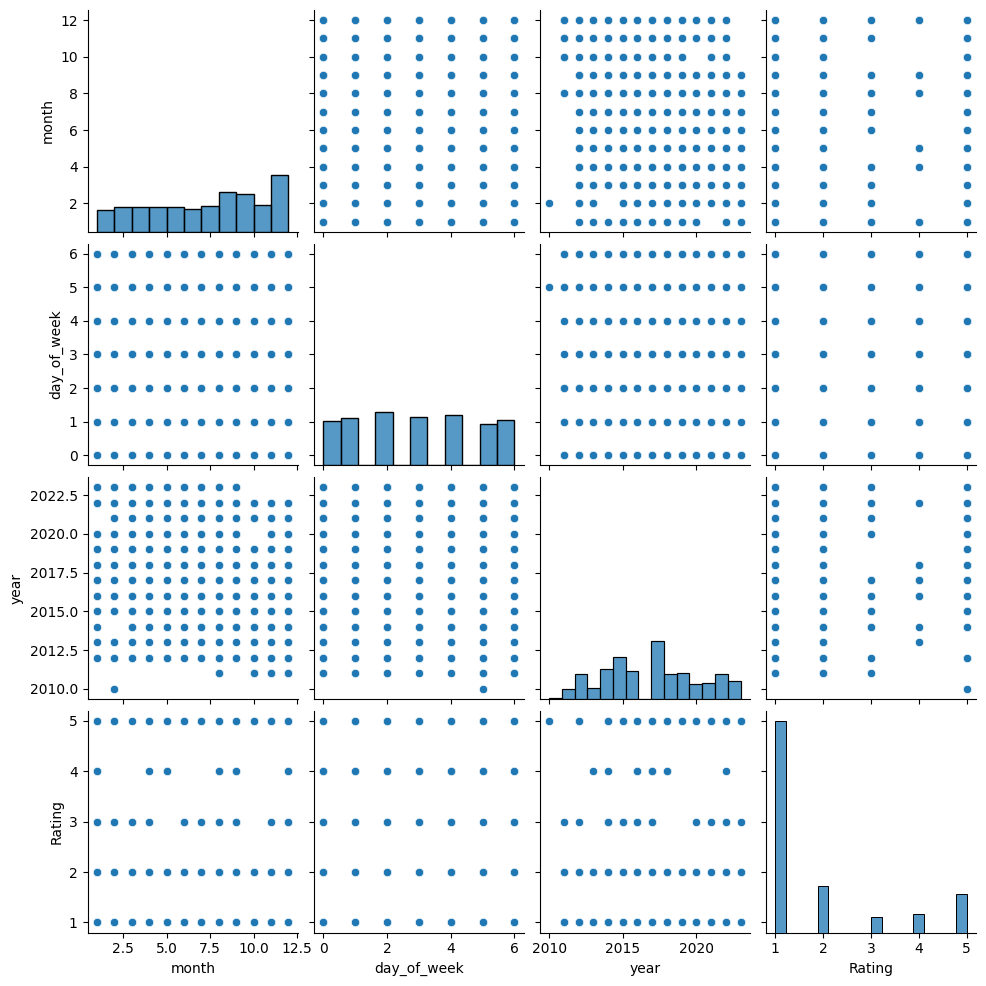

In [49]:
# Histograma das variáveis
sns.pairplot(df_treat[["month","day_of_week", "year", "Rating"]])

Não parece existir correlação entre o score e a data da avaliação.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    return sentence

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, token_pattern=None)

from sklearn.model_selection import train_test_split

X = df_treat['review_treat'] # the features we want to analyze
ylabels = df_treat['Rating'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [51]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=10000)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

/Users/abilioazevedo/.local/share/virtualenvs/trilha-ai-dev-q7YCxvZC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x286ceea10>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x2c66858a0>)),
                ('classifier', LogisticRegression(max_iter=10000))])

In [52]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='micro'))

Logistic Regression Accuracy: 0.6729857819905213
Logistic Regression Precision: 0.6729857819905213
Logistic Regression Recall: 0.6729857819905213


In [53]:
predicted_example = pipe.predict(["I didn't like this product at all"])
predicted_example[0]

1.0

In [54]:
predicted_example = pipe.predict(["I love this product"])
predicted_example[0]

5.0

In [55]:
# Save model
import joblib
joblib.dump(pipe, './review_model.pkl')

['./review_model.pkl']

In [56]:
model = joblib.load('./review_model.pkl')
predicted_example = model.predict(["I love this product"])
predicted_example[0]

5.0